# Ajuste do Modelo

In [1]:
# tool kit
import warnings
warnings.filterwarnings('ignore')

import math as m
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error

In [86]:
Queimadas_Pantanal = pd.read_csv('Queimadas_Pantanal_EDA.csv')

In [88]:
Queimadas_Pantanal.tail(7)

DATE  DIAS_SEM_CHUVA  RISCO_FOGO  PRECIPITACAO_DIARIA  \
2555  2020-12-30             3.0         0.7                  0.4   
2556  2020-12-31             3.0         0.7                  0.4   
2557  2021-01-31             0.0         0.0                  1.0   
2558  2021-02-01             0.0         0.0                  1.0   
2559  2021-02-03             3.0         0.0                  1.2   
2560  2021-02-04             3.0         0.0                  1.2   
2561  2021-02-05             3.0         0.0                  1.2   

      PRESSAO_ATMOSFERICA  TEMPERATURA_PONTO_DE_ORVALHO  TEMPERATURA_MAXIMA  \
2555               995.77                         21.24                35.5   
2556               995.77                         21.24                35.5   
2557               995.65                         22.18                32.9   
2558               995.65                         22.18                32.9   
2559               995.05                         22.90                34.8   
2560               995.05                         22.90                34.8   
2561               995.05                         22.90                34.8   

      TEMPERATURA_MEDIA  TEMPERATURA_MINIMA  UMIDADE_RELATIVA_DO_AR_MEDIA  \
2555              29.27                25.1                         64.22   
2556              29.27                25.1                         64.22   
2557              27.56                 0.0                         73.29   
2558              27.56                 0.0                         73.29   
2559              29.39                25.3                         69.50   
2560              29.39                25.3                         69.50   
2561              29.39                25.3                         69.50   

      UMIDADE_RELATIVA_MINIMA_DO_AR  VENTO_RAJADA_MAXIMA  \
2555                           37.0                  8.7   
2556                           37.0                  8.7   
2557                           52.0                  7.4   
2558                           52.0                  7.4   
2559                           47.0                  7.5   
2560                           47.0                  7.5   
2561                           47.0                  7.5   

      VENTO_VELOCIDADE_MEDIA  
2555                    0.62  
2556                    0.62  
2557                    0.25  
2558                    0.25  
2559                    0.26  
2560                    0.26  
2561                    0.26

### Colocar nosso index como um "DatetimeIndex"

In [89]:
Queimadas_Pantanal.set_index('DATE', drop=True, inplace=True)
Queimadas_Pantanal.index = pd.DatetimeIndex(Queimadas_Pantanal.index)

In [90]:
Queimadas_Pantanal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2562 entries, 2014-01-03 to 2021-02-05
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DIAS_SEM_CHUVA                 2562 non-null   float64
 1   RISCO_FOGO                     2562 non-null   float64
 2   PRECIPITACAO_DIARIA            2562 non-null   float64
 3   PRESSAO_ATMOSFERICA            2562 non-null   float64
 4   TEMPERATURA_PONTO_DE_ORVALHO   2562 non-null   float64
 5   TEMPERATURA_MAXIMA             2562 non-null   float64
 6   TEMPERATURA_MEDIA              2562 non-null   float64
 7   TEMPERATURA_MINIMA             2562 non-null   float64
 8   UMIDADE_RELATIVA_DO_AR_MEDIA   2562 non-null   float64
 9   UMIDADE_RELATIVA_MINIMA_DO_AR  2562 non-null   float64
 10  VENTO_RAJADA_MAXIMA            2562 non-null   float64
 11  VENTO_VELOCIDADE_MEDIA         2562 non-null   float64
dtypes: float64(12)
memory usage: 2

In [91]:
Queimadas_Pantanal.columns

Index(['DIAS_SEM_CHUVA', 'RISCO_FOGO', 'PRECIPITACAO_DIARIA',
       'PRESSAO_ATMOSFERICA', 'TEMPERATURA_PONTO_DE_ORVALHO',
       'TEMPERATURA_MAXIMA', 'TEMPERATURA_MEDIA', 'TEMPERATURA_MINIMA',
       'UMIDADE_RELATIVA_DO_AR_MEDIA', 'UMIDADE_RELATIVA_MINIMA_DO_AR',
       'VENTO_RAJADA_MAXIMA', 'VENTO_VELOCIDADE_MEDIA'],
      dtype='object')

### EDA

#### Análise da Estacionariedade

In [92]:
# Função Estacionariedade
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # ADF Test
    result = adfuller(timeseries, autolag='AIC')

    print('Augmented Dickey Fuller test (ADH Test)')
    print('='*40)
    print(f'ADF Statistic: {result[0]:>24}')
    print('-'*40)
    print(f'p-value:       {result[1]:>24}')
    print('-'*40)
    print('Critial Values:')
    print('-'*40)
    for key, value in result[4].items():
        print(f'{key:>4} :{value:>33}')
    print('='*40)

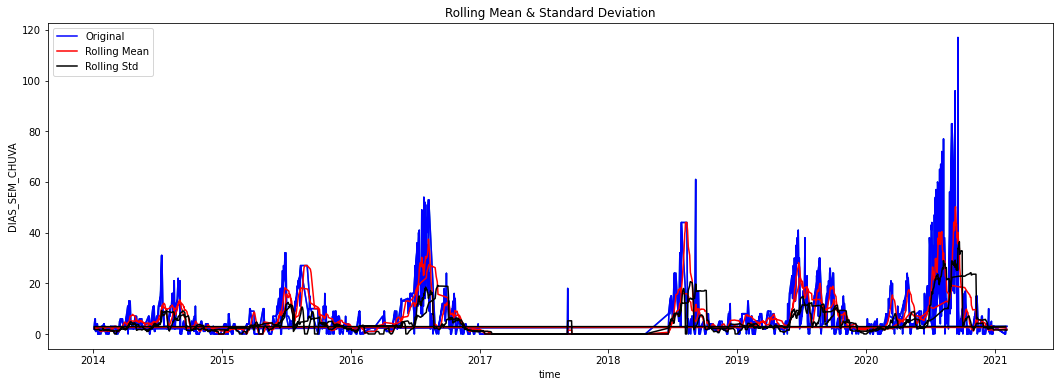

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -5.6380119247955705
----------------------------------------
p-value:          1.052157551144271e-06
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329301847920486
  5% :               -2.862679919243664
 10% :              -2.5673768219208686


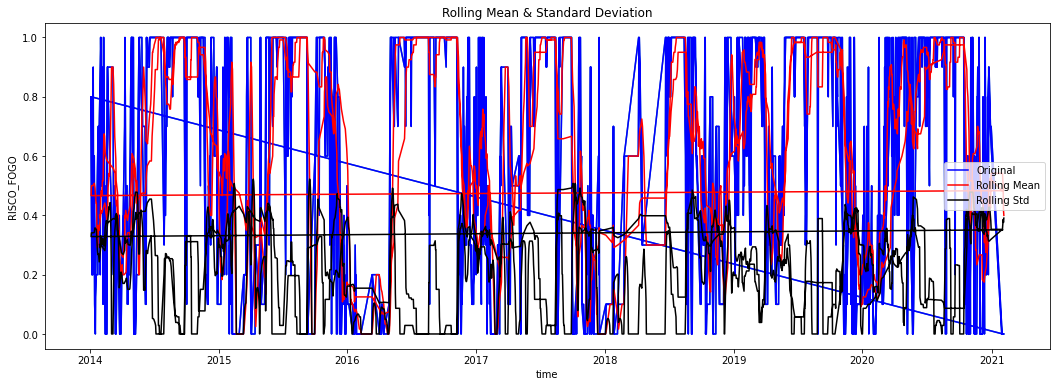

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -6.045535498065707
----------------------------------------
p-value:          1.314630922673695e-07
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432923078043983
  5% :              -2.8626767808549087
 10% :                -2.56737515100891


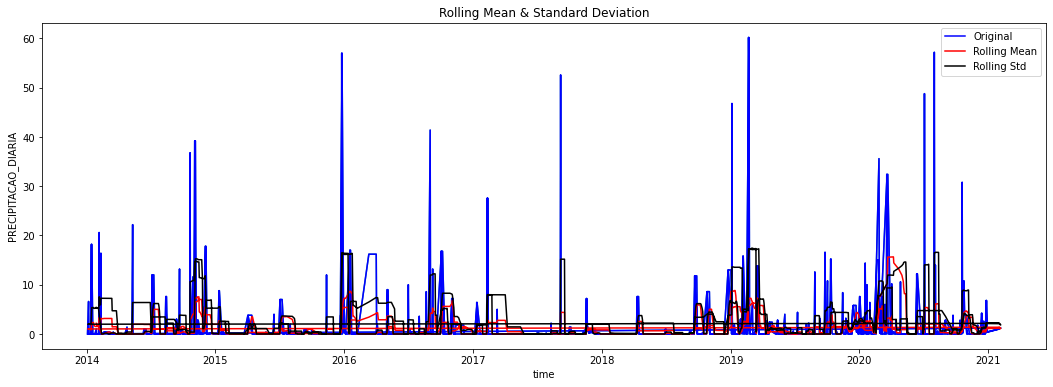

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -23.72661272135821
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329079803530984
  5% :               -2.862670113586149
 10% :              -2.5673716012873826


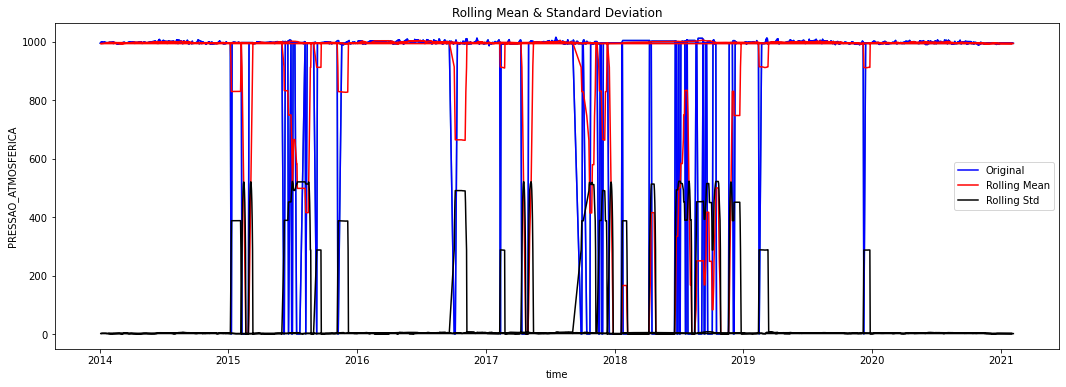

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -3.8701020083640896
----------------------------------------
p-value:          0.0022662362861799595
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329271342415577
  5% :              -2.8626785721005303
 10% :              -2.5673761046872094


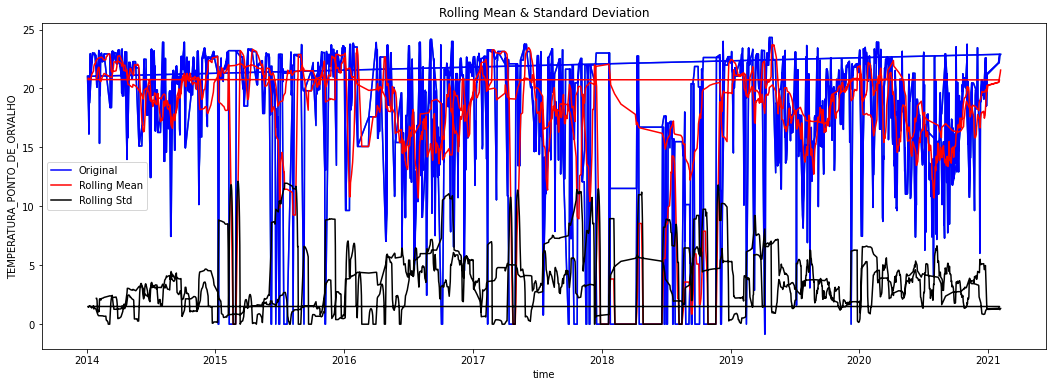

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -4.943072906123996
----------------------------------------
p-value:         2.8731592261803914e-05
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432922065988844
  5% :              -2.8626763339238015
 10% :              -2.5673749130580785


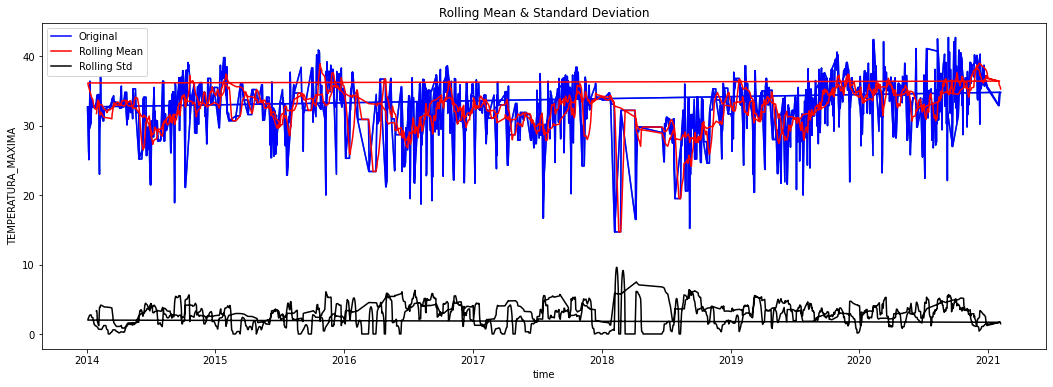

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -8.972828058713525
----------------------------------------
p-value:          7.671407568639503e-15
----------------------------------------
Critial Values:
----------------------------------------
  1% :                -3.43291399811863
  5% :              -2.8626727710866504
 10% :              -2.5673730161669357


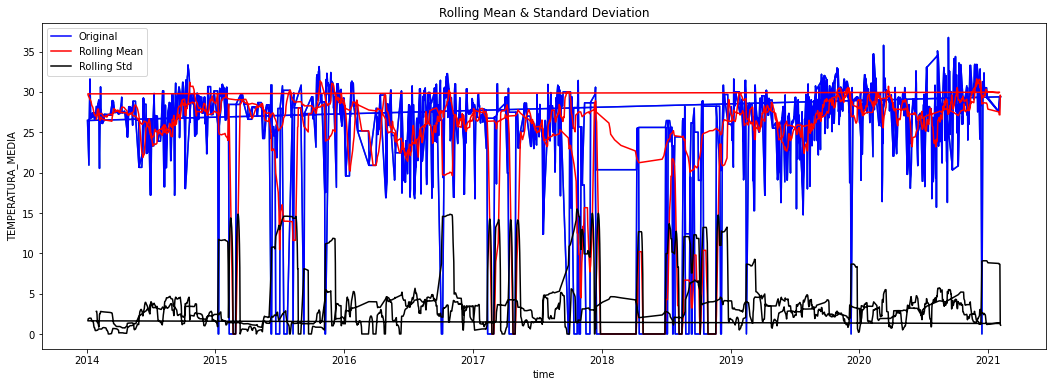

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -4.224880738512456
----------------------------------------
p-value:          0.0005978348196055307
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329271342415577
  5% :              -2.8626785721005303
 10% :              -2.5673761046872094


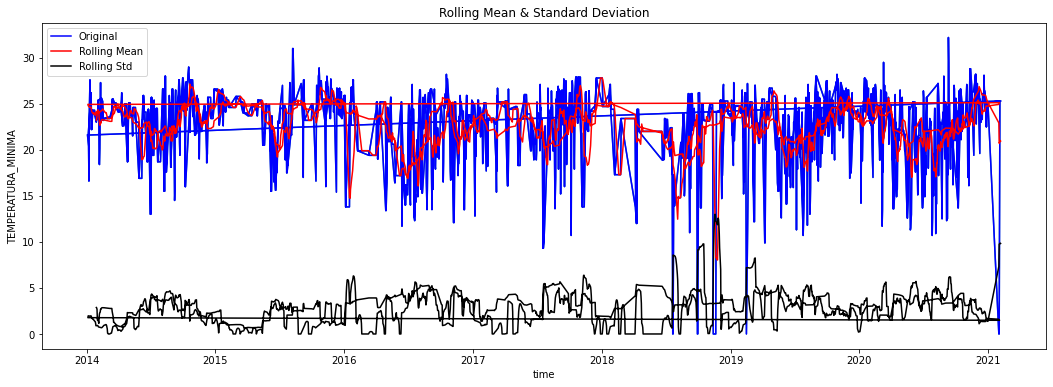

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -13.45158570025318
----------------------------------------
p-value:         3.6750970930782517e-25
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329109857007527
  5% :               -2.862671440775931
 10% :              -2.5673723078962385


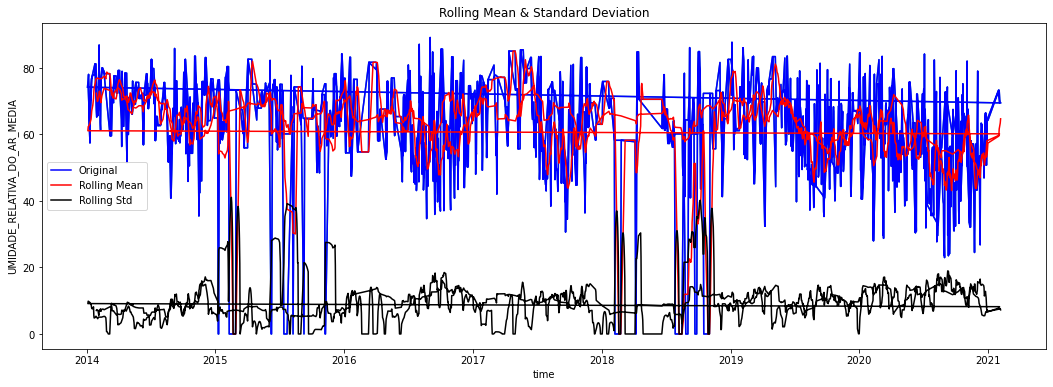

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -10.422719411907233
----------------------------------------
p-value:          1.688269903261861e-18
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432911989053234
  5% :              -2.8626718838655236
 10% :              -2.5673725438015325


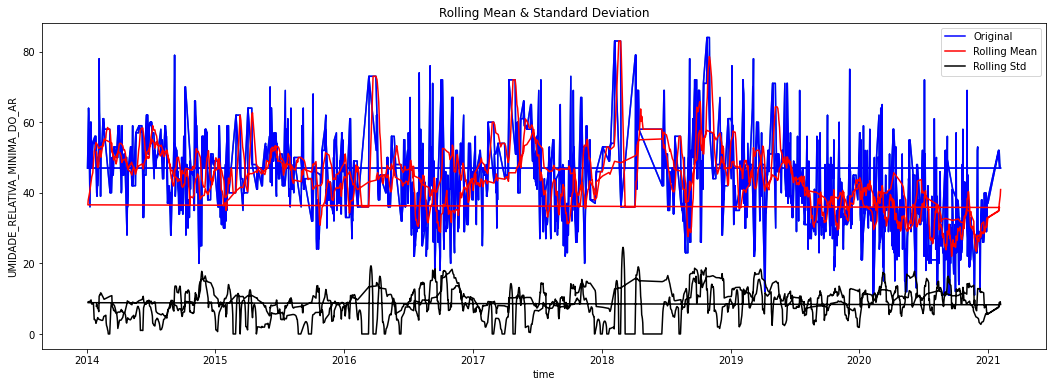

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -11.162152774945184
----------------------------------------
p-value:          2.770750550085113e-20
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432909983133851
  5% :               -2.862670998033109
 10% :              -2.5673720721755933


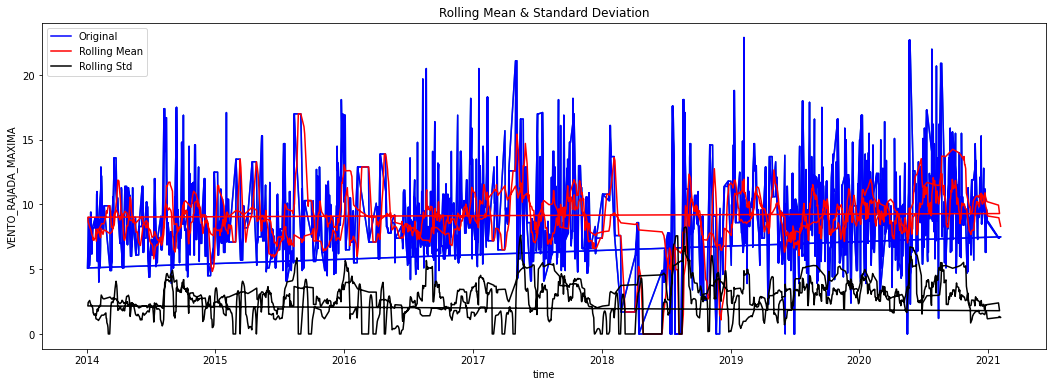

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -7.291028997947014
----------------------------------------
p-value:         1.4171124118841218e-10
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432923078043983
  5% :              -2.8626767808549087
 10% :                -2.56737515100891


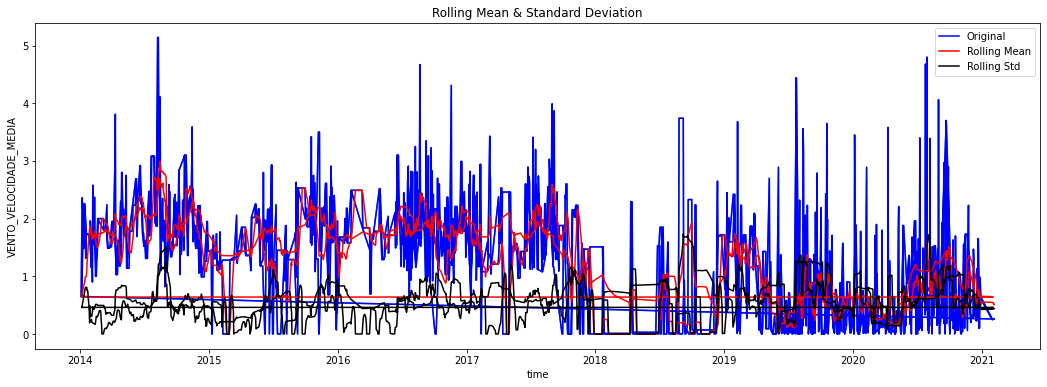

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -4.227772143432194
----------------------------------------
p-value:          0.0005910944790422075
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329240908958814
  5% :              -2.8626772281377195
 10% :              -2.5673753891470175


In [93]:
# Agora sim! Conseguimos começar a EDA da nossa série com mais segurança!
cols = Queimadas_Pantanal.columns

for i in cols:
    
    # Vamos ver sua distribuição real!
    plt.figure(figsize=(18, 6))
    plt.plot(Queimadas_Pantanal[i])

    plt.title(i)
    plt.ylabel(i)
    plt.xlabel('time')
    test_stationarity(Queimadas_Pantanal[i])

In [ ]:
# Verificamos que os valores não estão estacionários

#### Identificação de Sazonalidade, Trend e Resíduos

<Figure size 432x288 with 0 Axes>

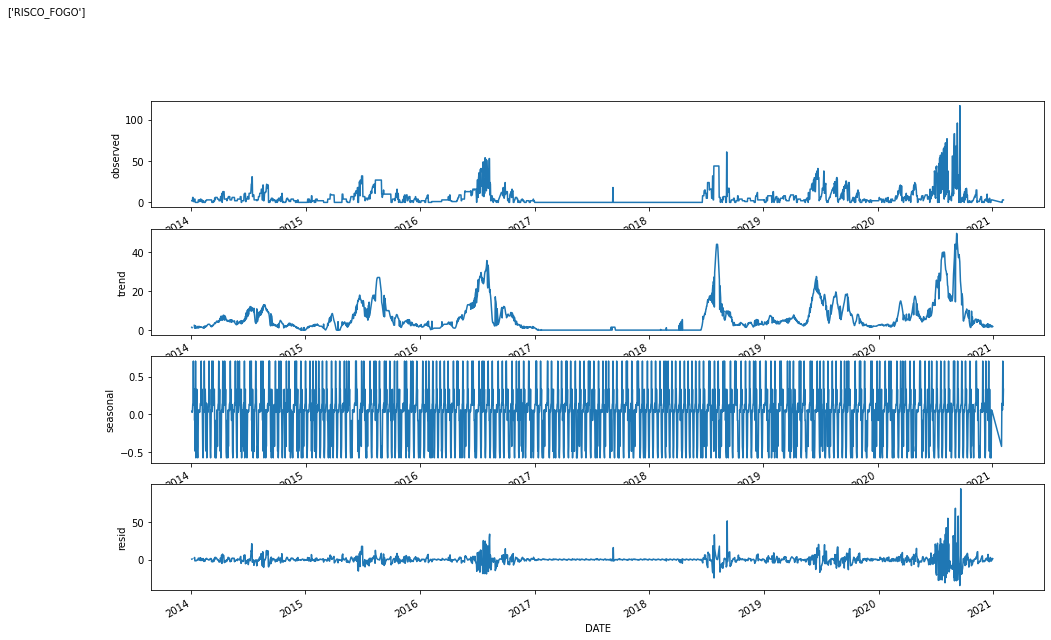

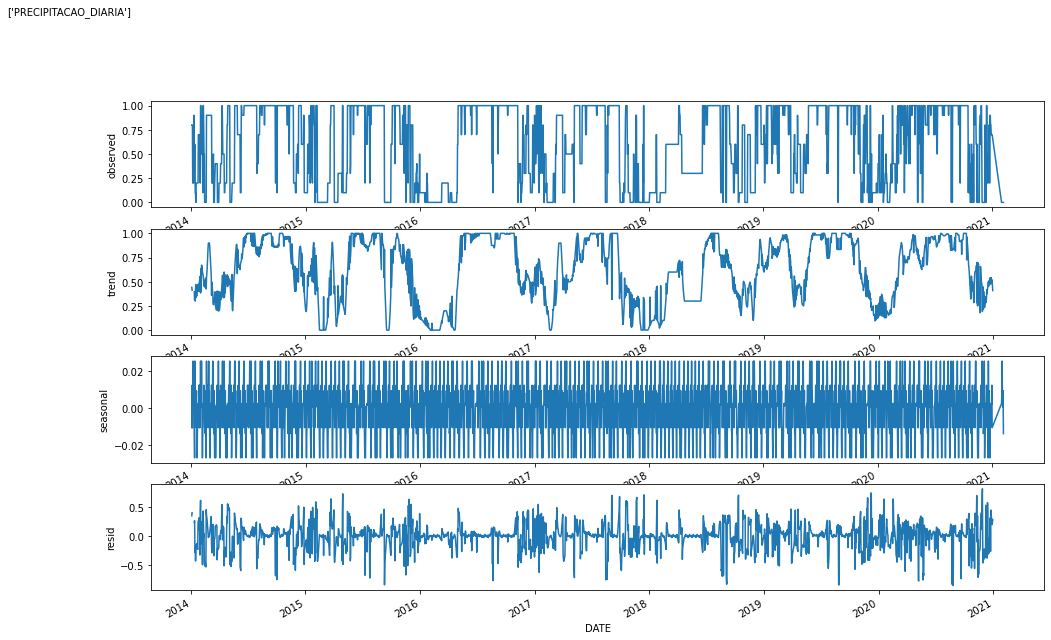

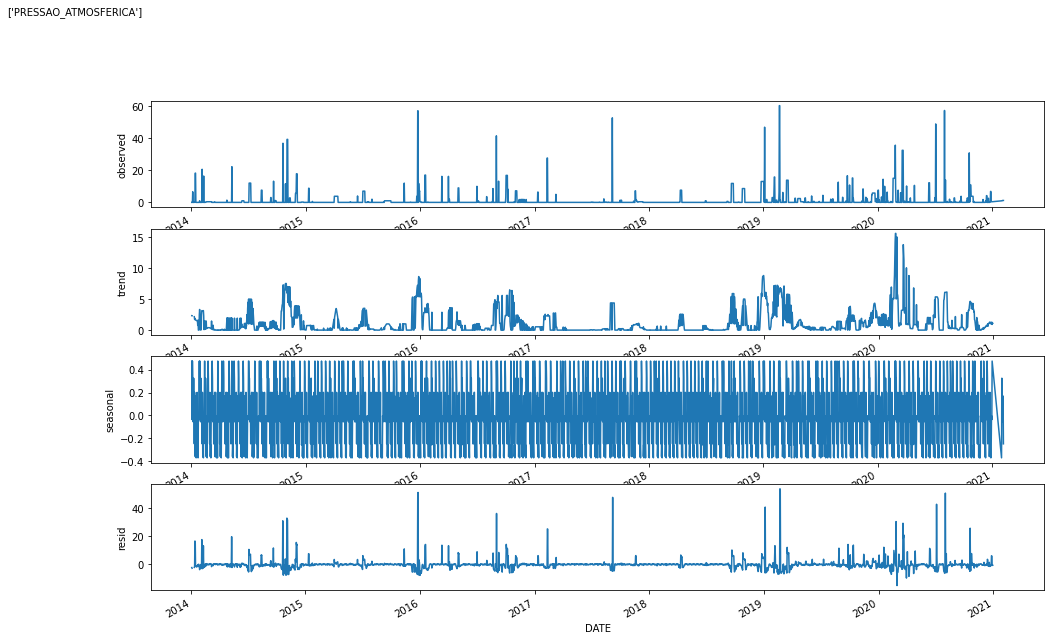

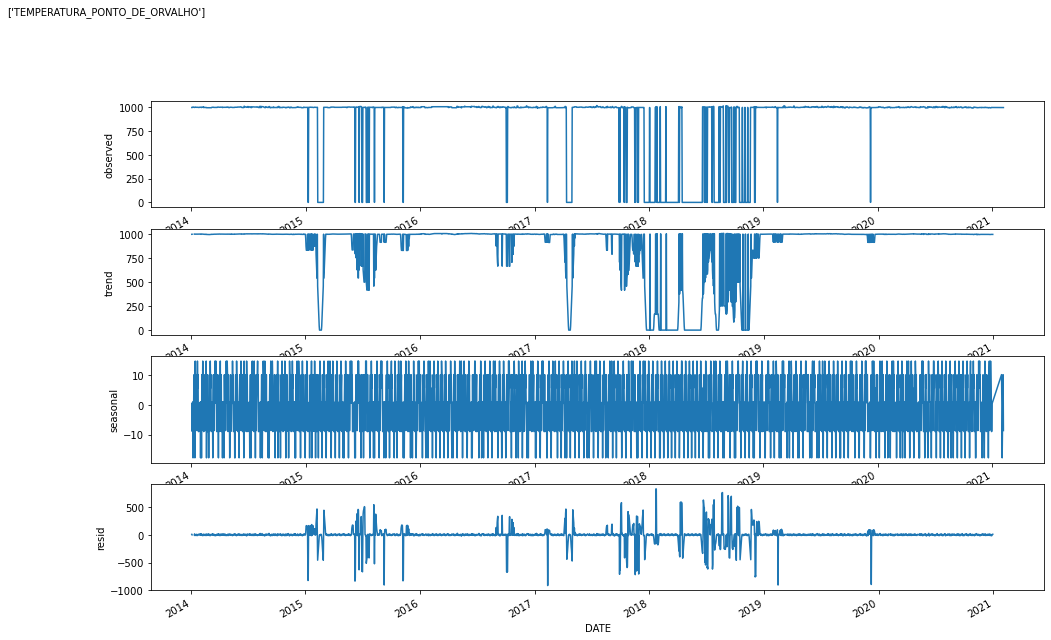

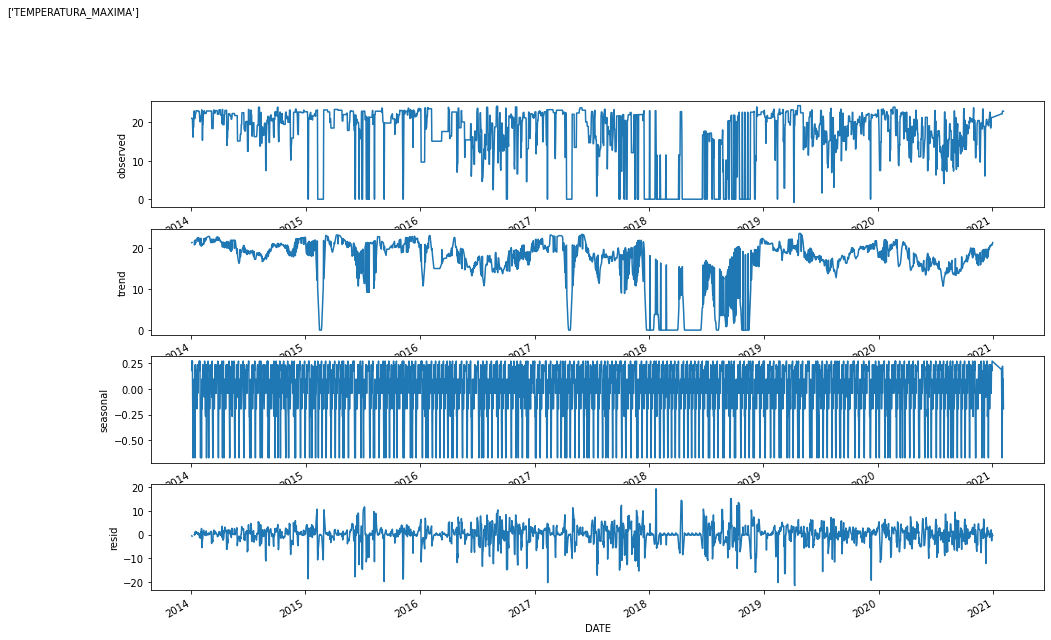

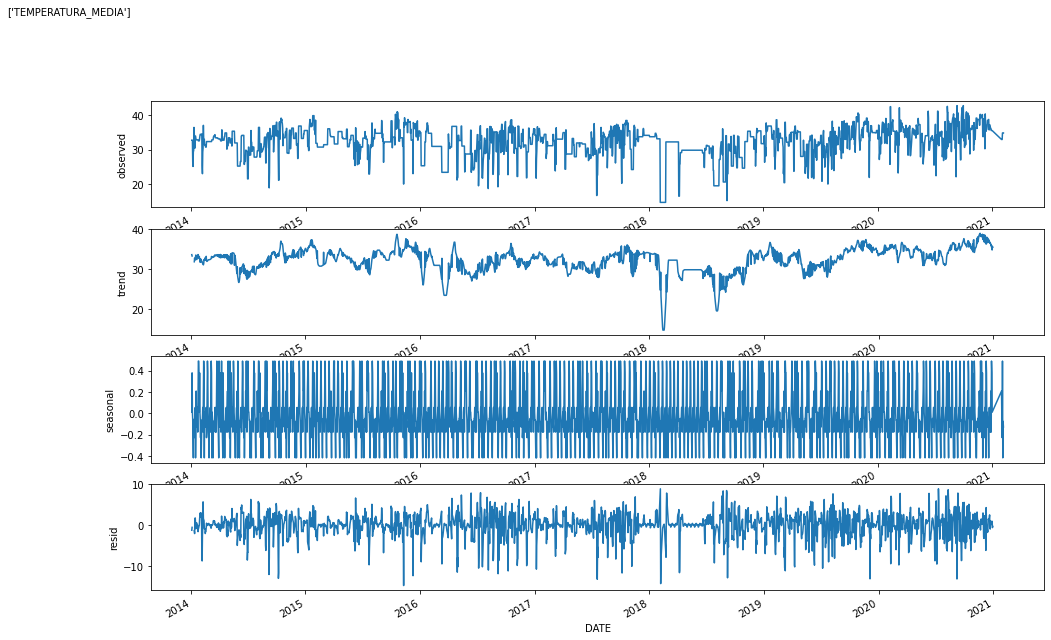

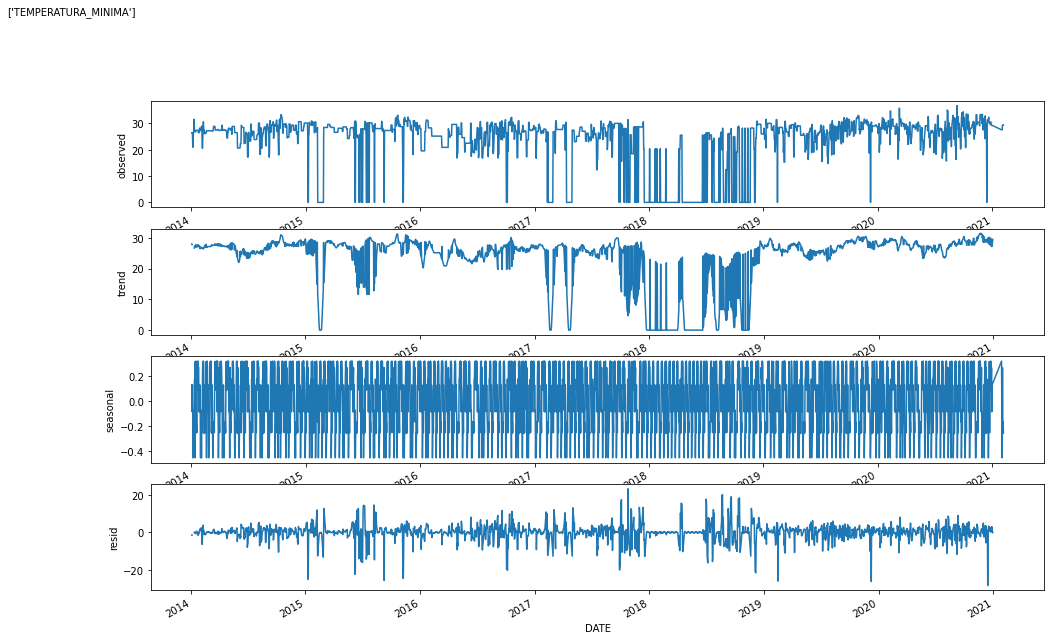

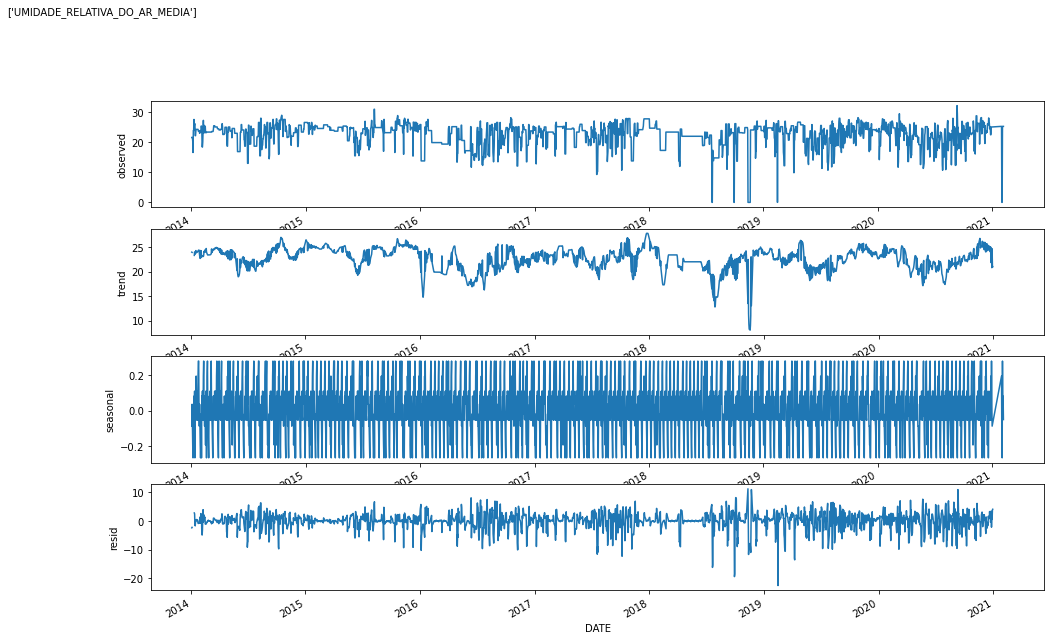

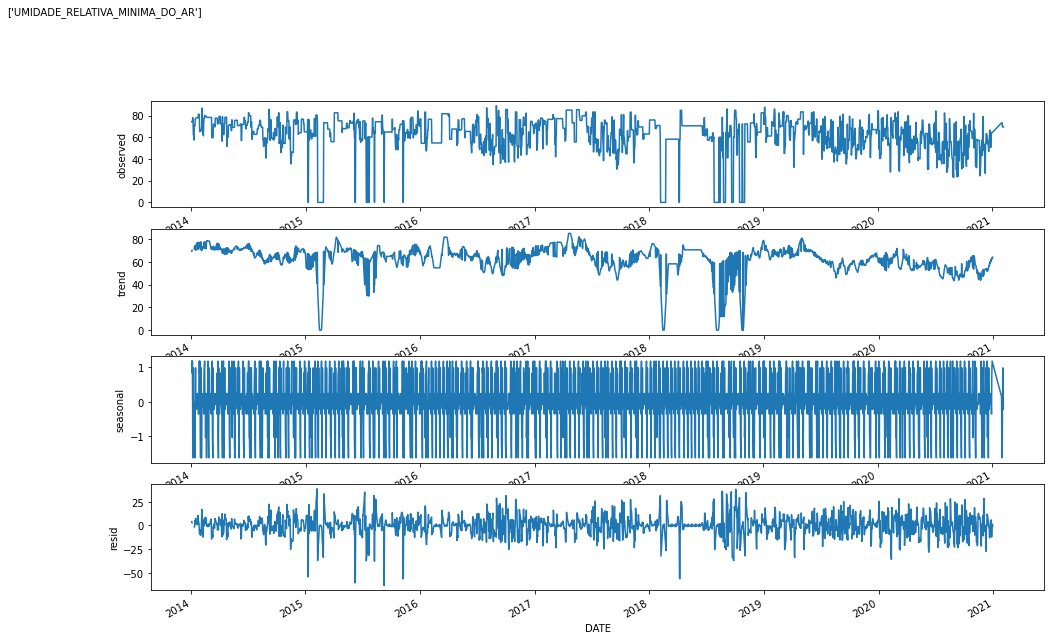

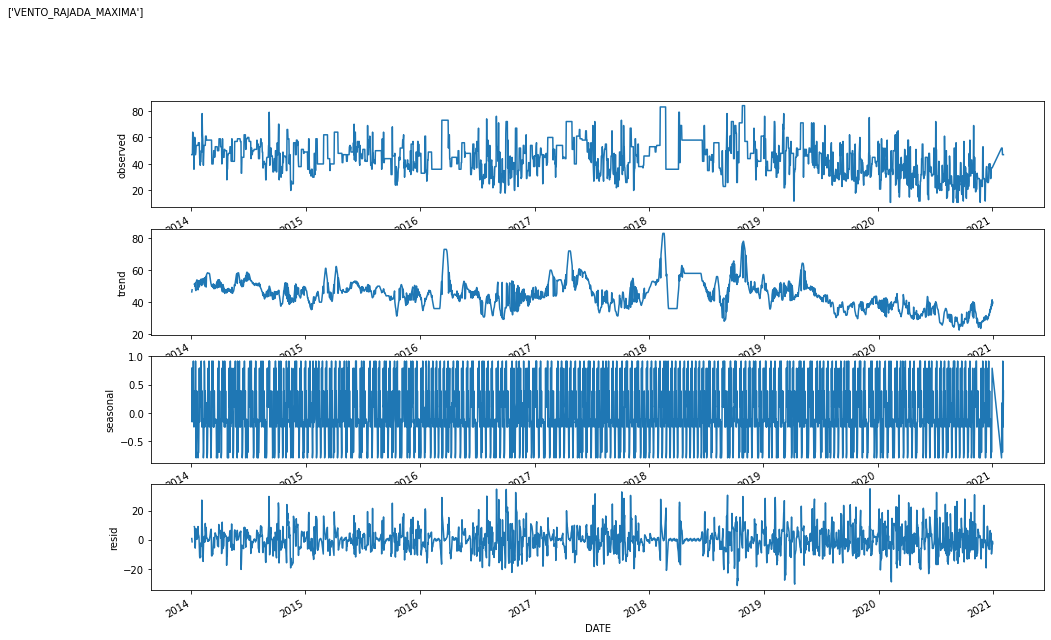

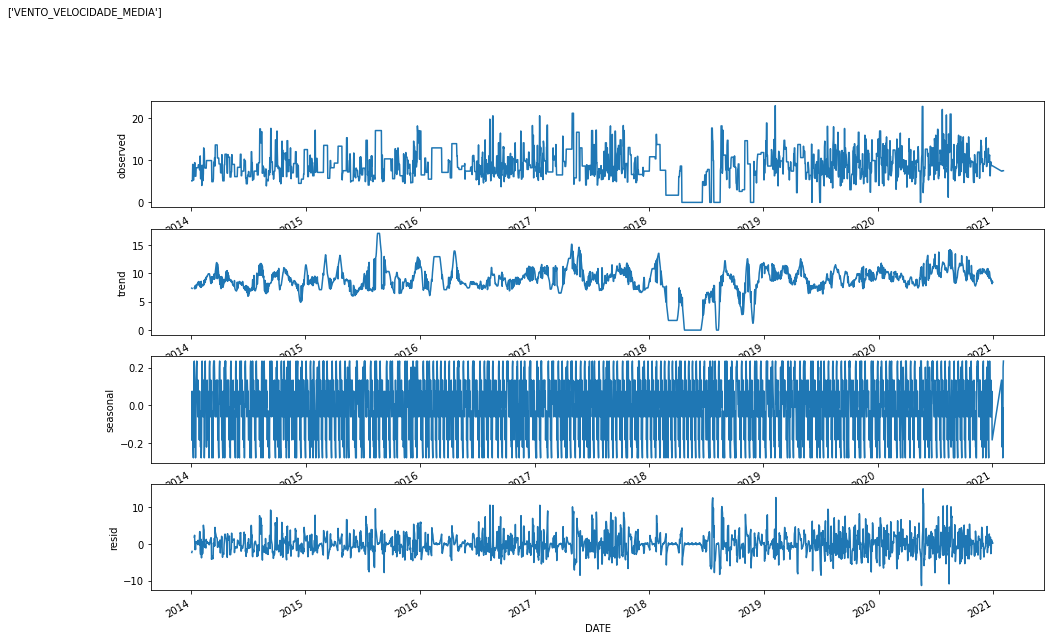

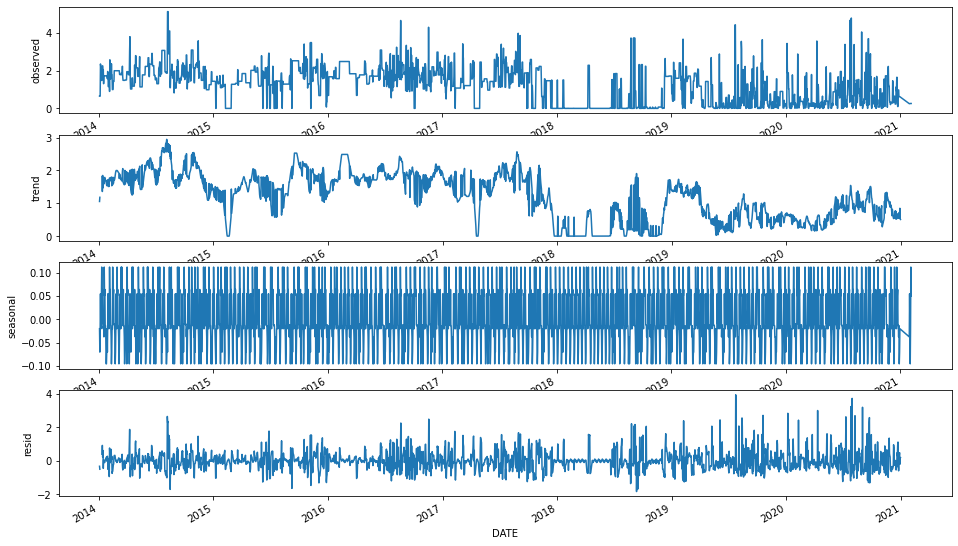

In [94]:
for i in cols:

    # Vamos realizar uma decomposição aditiva da nossa série, e estudar sua tendência, sazonalidade e resíduo.
    decomposition = seasonal_decompose(Queimadas_Pantanal[i], freq=12)
    
    textstr = [i]
    plt.gcf().text(0, 1, textstr, fontsize=10)
    
    fig, ax = plt.subplots(4, 1, figsize=(16, 10))
    decomposition.observed.plot(ax=ax[0]); ax[0].set_ylabel('observed')
    decomposition.trend.plot(ax=ax[1]); ax[1].set_ylabel('trend')
    decomposition.seasonal.plot(ax=ax[2]); ax[2].set_ylabel('seasonal')
    decomposition.resid.plot(ax=ax[3]); ax[3].set_ylabel('resid');

### Diferenciação utilizando shift()

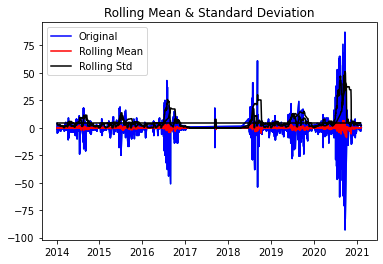

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -14.255577595679153
----------------------------------------
p-value:         1.4559567160698564e-26
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329301847920486
  5% :               -2.862679919243664
 10% :              -2.5673768219208686


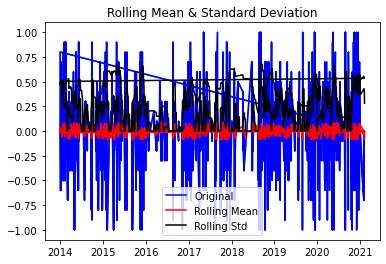

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:        -17.7974848289941
----------------------------------------
p-value:          3.228246520358157e-30
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432923078043983
  5% :              -2.8626767808549087
 10% :                -2.56737515100891


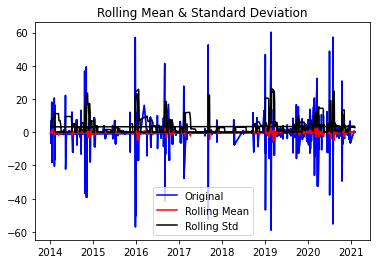

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -18.808146843985178
----------------------------------------
p-value:         2.0225430118981322e-30
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329322225076955
  5% :              -2.8626808191115116
 10% :               -2.567377301020428


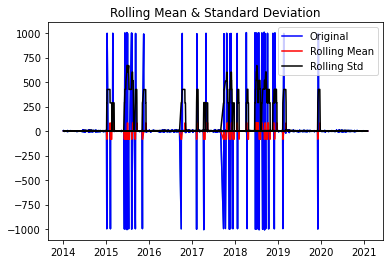

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -15.193887082401673
----------------------------------------
p-value:          5.957941502091363e-28
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329271342415577
  5% :              -2.8626785721005303
 10% :              -2.5673761046872094


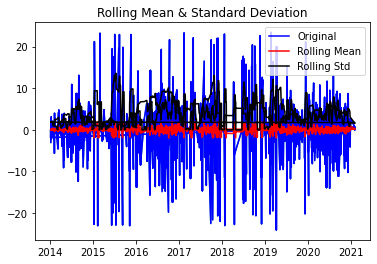

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -15.14260100722249
----------------------------------------
p-value:          6.976470921836802e-28
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329301847920486
  5% :               -2.862679919243664
 10% :              -2.5673768219208686


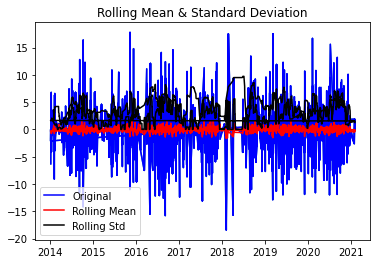

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -15.298174794151643
----------------------------------------
p-value:          4.349310204101438e-28
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329301847920486
  5% :               -2.862679919243664
 10% :              -2.5673768219208686


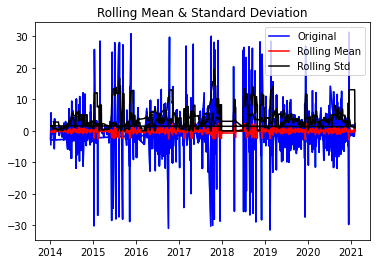

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -14.263121668942459
----------------------------------------
p-value:         1.4154329537753888e-26
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329301847920486
  5% :               -2.862679919243664
 10% :              -2.5673768219208686


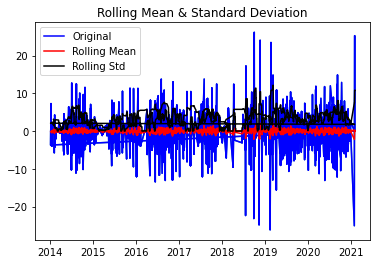

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -16.060948112359505
----------------------------------------
p-value:          5.639797539059732e-29
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329301847920486
  5% :               -2.862679919243664
 10% :              -2.5673768219208686


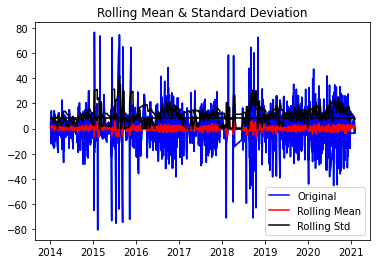

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -16.115460476332235
----------------------------------------
p-value:          4.961404714210483e-29
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329301847920486
  5% :               -2.862679919243664
 10% :              -2.5673768219208686


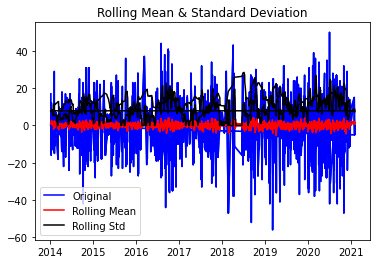

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -16.787481136030326
----------------------------------------
p-value:         1.2497943406285927e-29
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329301847920486
  5% :               -2.862679919243664
 10% :              -2.5673768219208686


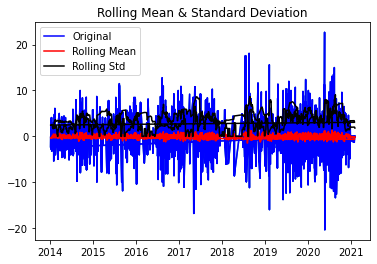

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -14.849791876137493
----------------------------------------
p-value:          1.784355603394329e-27
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432934263444484
  5% :              -2.8626817204012203
 10% :              -2.5673777808771043


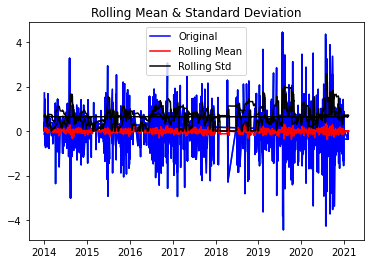

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -18.40549955722442
----------------------------------------
p-value:         2.1886931644930013e-30
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329240908958814
  5% :              -2.8626772281377195
 10% :              -2.5673753891470175


In [95]:
Queimadas_Pantanal_diff = Queimadas_Pantanal - Queimadas_Pantanal.shift()

for i in cols:
    plt.plot(Queimadas_Pantanal_diff[i])
    test_stationarity(Queimadas_Pantanal_diff[i].dropna());

### Realizado um novo Shift para redução da Não Estacionariedade.

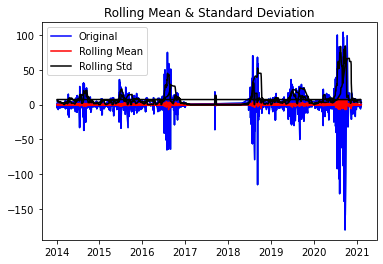

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -19.056961827740093
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329352851231945
  5% :               -2.862682171580326
 10% :              -2.5673780210899224


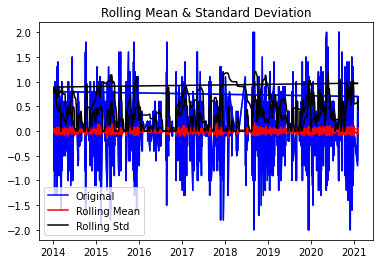

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -19.54568555856434
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329352851231945
  5% :               -2.862682171580326
 10% :              -2.5673780210899224


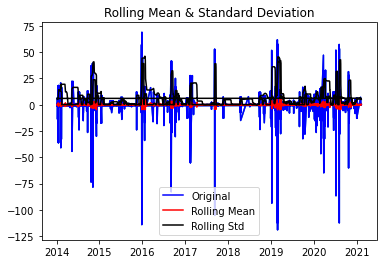

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -21.41873333828423
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329352851231945
  5% :               -2.862682171580326
 10% :              -2.5673780210899224


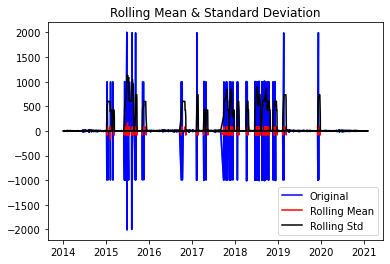

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -19.83557665280663
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :                -3.43293324257297
  5% :              -2.8626812695784225
 10% :              -2.5673775408540145


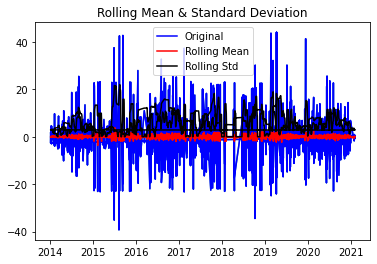

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -19.62828866945597
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329352851231945
  5% :               -2.862682171580326
 10% :              -2.5673780210899224


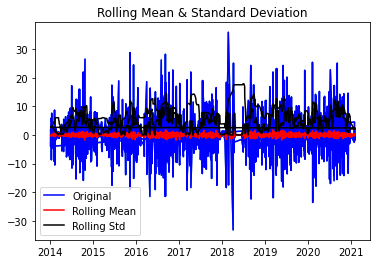

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -19.31698106113072
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329352851231945
  5% :               -2.862682171580326
 10% :              -2.5673780210899224


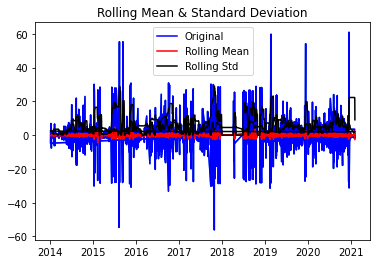

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -19.576099312307132
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :                -3.43293324257297
  5% :              -2.8626812695784225
 10% :              -2.5673775408540145


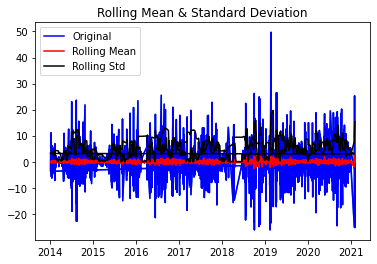

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -19.95894773639536
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329352851231945
  5% :               -2.862682171580326
 10% :              -2.5673780210899224


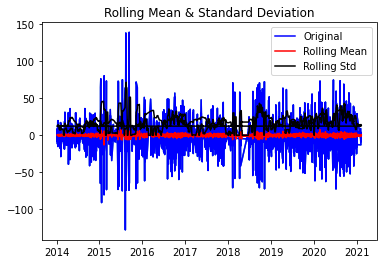

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -19.829694754250852
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329352851231945
  5% :               -2.862682171580326
 10% :              -2.5673780210899224


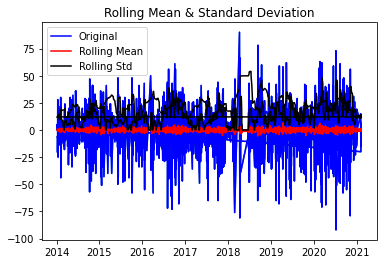

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -20.42572232324825
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329352851231945
  5% :               -2.862682171580326
 10% :              -2.5673780210899224


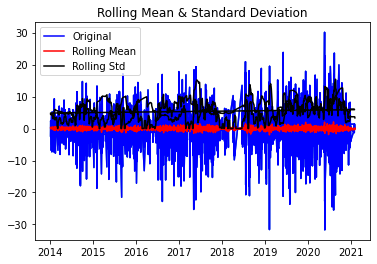

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -18.640662628863037
----------------------------------------
p-value:         2.0542000794457467e-30
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329352851231945
  5% :               -2.862682171580326
 10% :              -2.5673780210899224


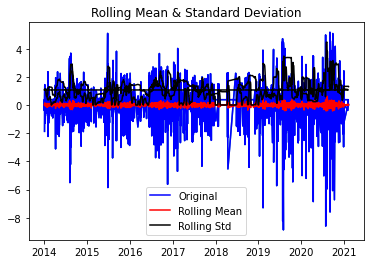

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -19.396180769655317
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :              -3.4329352851231945
  5% :               -2.862682171580326
 10% :              -2.5673780210899224


In [96]:
Queimadas_Pantanal_diff2 = Queimadas_Pantanal_diff - Queimadas_Pantanal_diff.shift()

for i in cols:
    plt.plot(Queimadas_Pantanal_diff2[i])
    test_stationarity(Queimadas_Pantanal_diff2[i].dropna());

### Realizado um novo Shift para redução da Não Estacionariedade.

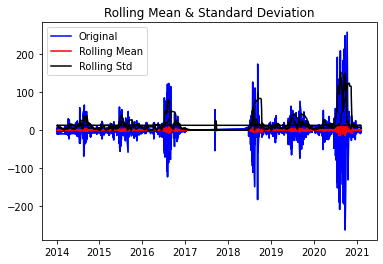

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -22.887843190197653
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432936307610058
  5% :              -2.8626826231161626
 10% :               -2.567378261492694


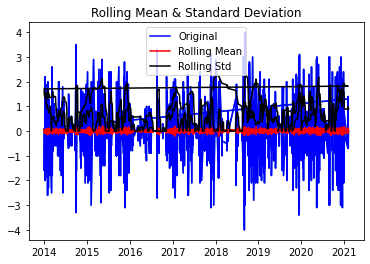

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -22.721897342839288
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432936307610058
  5% :              -2.8626826231161626
 10% :               -2.567378261492694


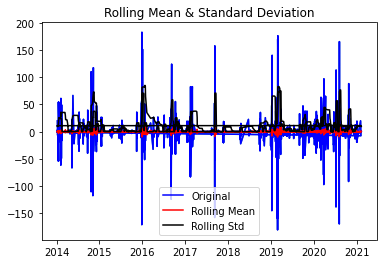

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -23.163066986038412
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432936307610058
  5% :              -2.8626826231161626
 10% :               -2.567378261492694


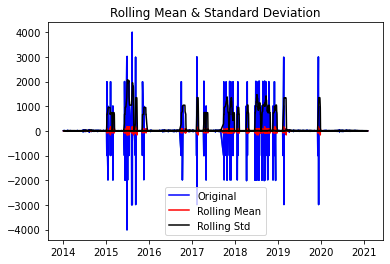

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -23.475775695438013
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432936307610058
  5% :              -2.8626826231161626
 10% :               -2.567378261492694


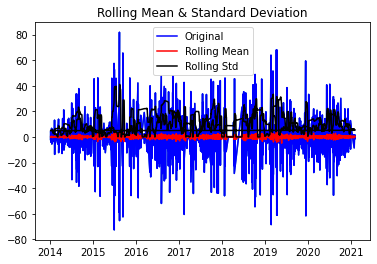

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -23.538072467130657
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432936307610058
  5% :              -2.8626826231161626
 10% :               -2.567378261492694


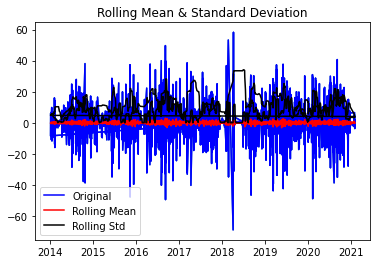

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -23.363718322608168
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432936307610058
  5% :              -2.8626826231161626
 10% :               -2.567378261492694


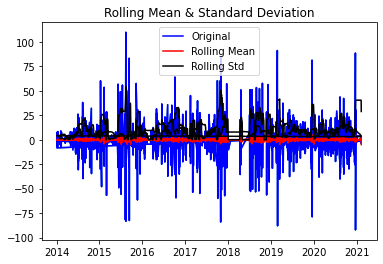

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -23.914313483067698
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432936307610058
  5% :              -2.8626826231161626
 10% :               -2.567378261492694


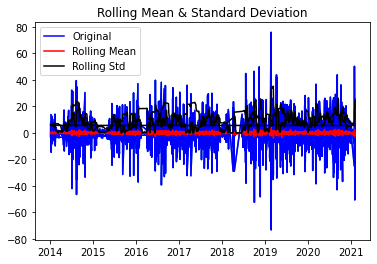

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -23.559754374489227
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432936307610058
  5% :              -2.8626826231161626
 10% :               -2.567378261492694


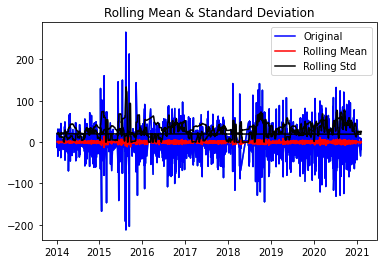

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -22.910925053959822
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432936307610058
  5% :              -2.8626826231161626
 10% :               -2.567378261492694


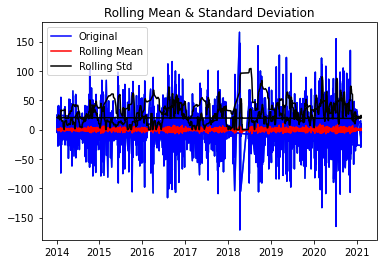

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:       -22.25982496016251
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432936307610058
  5% :              -2.8626826231161626
 10% :               -2.567378261492694


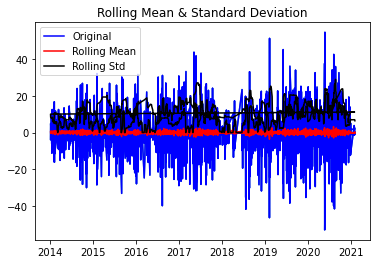

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -23.037494159234598
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432936307610058
  5% :              -2.8626826231161626
 10% :               -2.567378261492694


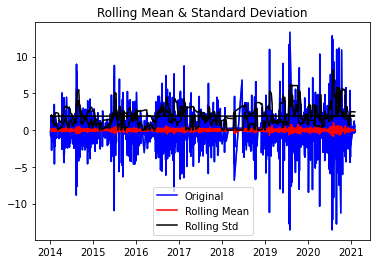

Augmented Dickey Fuller test (ADH Test)
ADF Statistic:      -23.639282132291676
----------------------------------------
p-value:                            0.0
----------------------------------------
Critial Values:
----------------------------------------
  1% :               -3.432936307610058
  5% :              -2.8626826231161626
 10% :               -2.567378261492694


In [97]:
Queimadas_Pantanal_diff3 = Queimadas_Pantanal_diff2 - Queimadas_Pantanal_diff2.shift()

for i in cols:
    plt.plot(Queimadas_Pantanal_diff3[i])
    test_stationarity(Queimadas_Pantanal_diff3[i].dropna());

In [ ]:
# De acordo com os valores apresentados, verificamos que os gráficos tornaram-se estacionários.

### Forecasting

#### Verificar se a média está representando corretamente a distribuição

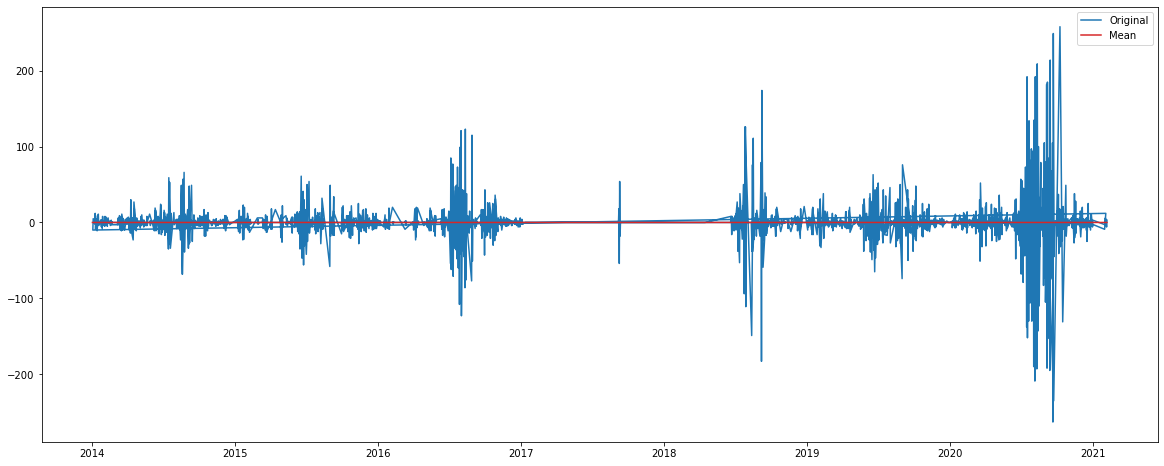

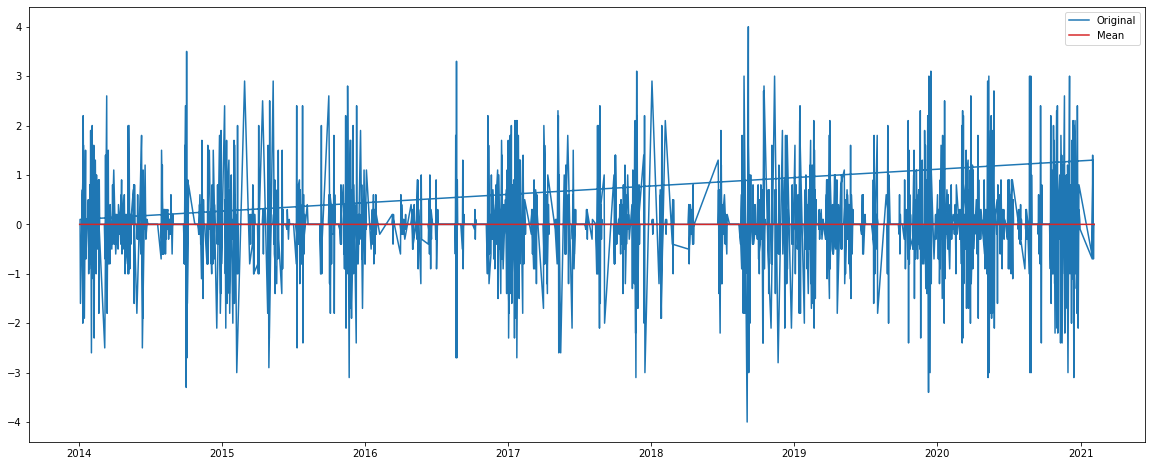

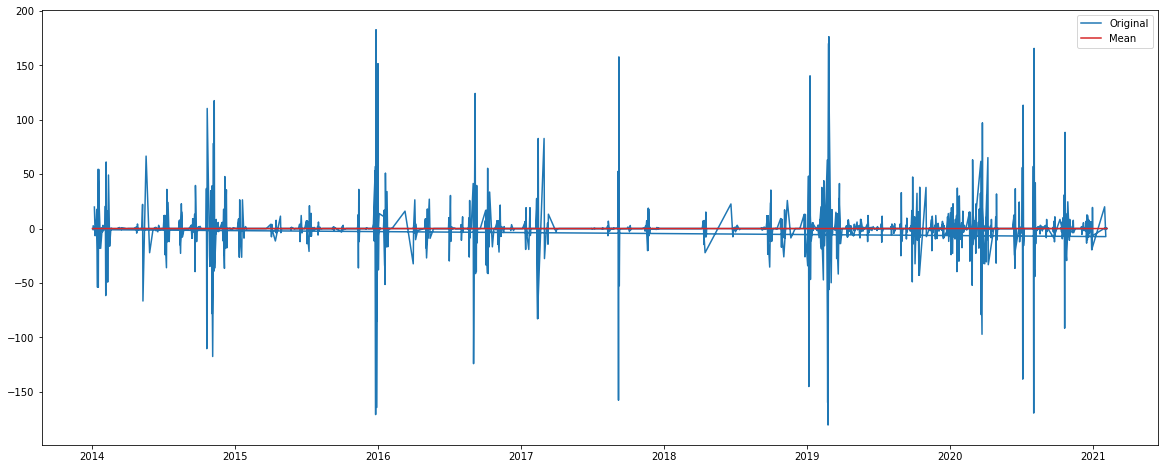

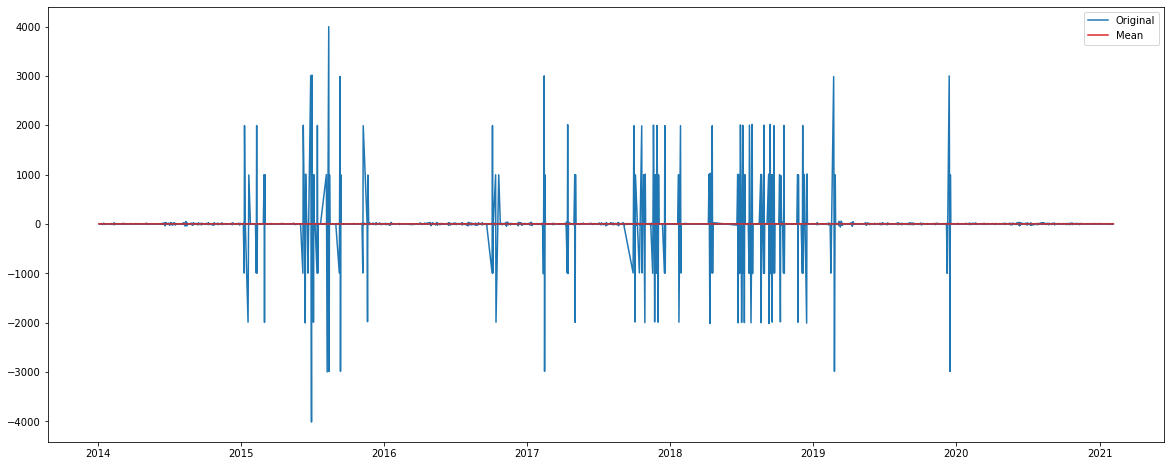

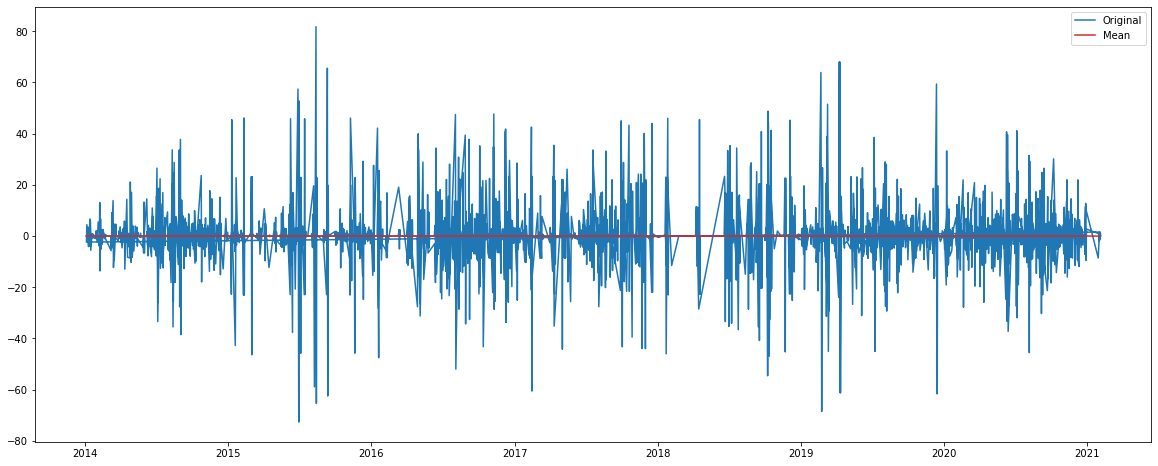

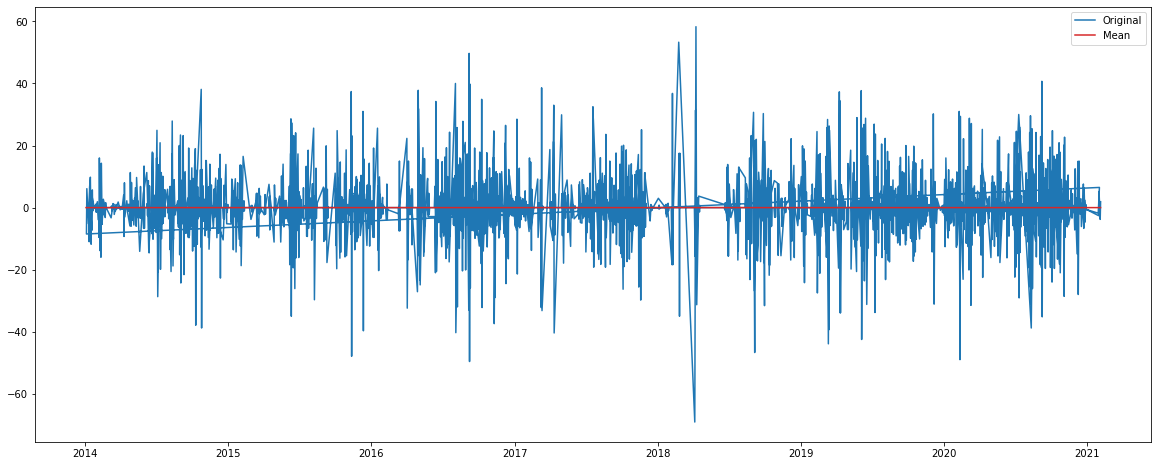

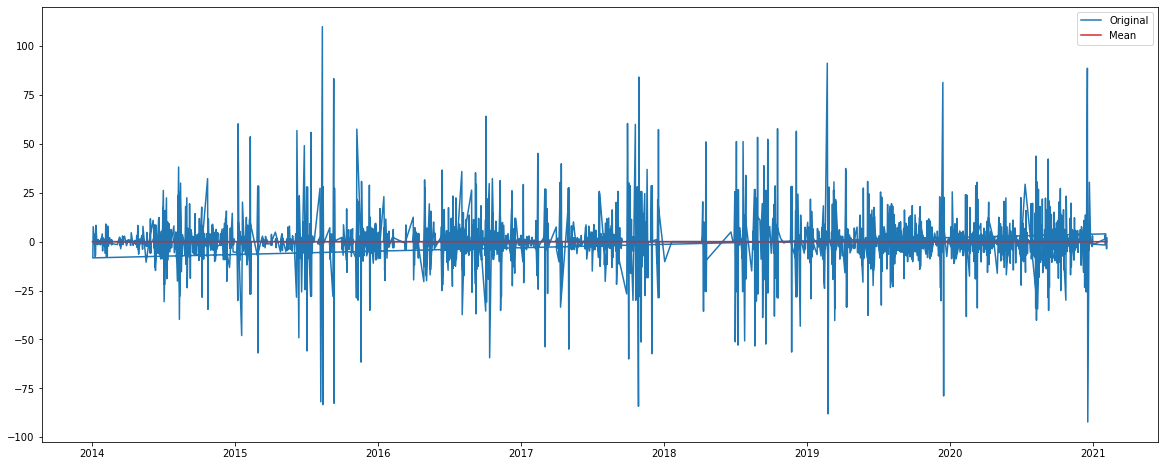

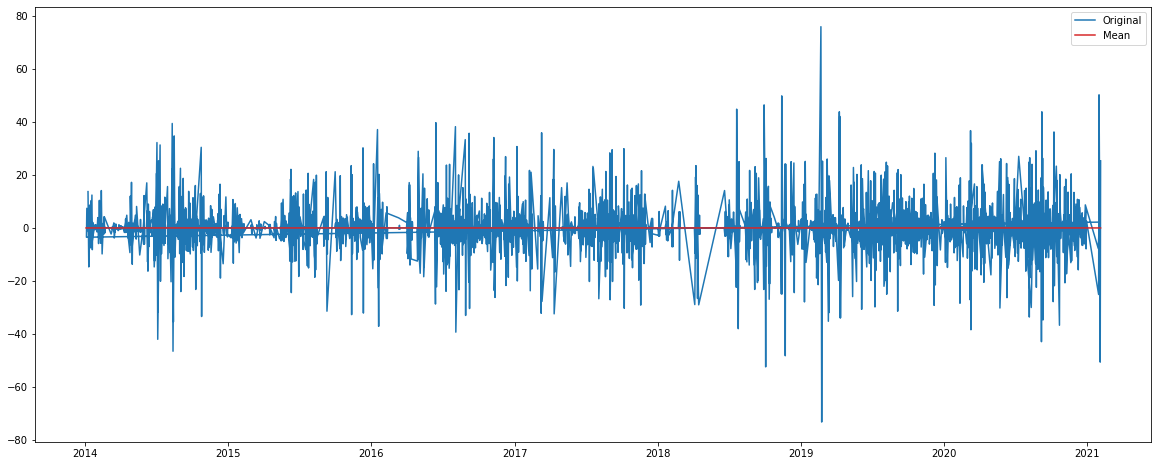

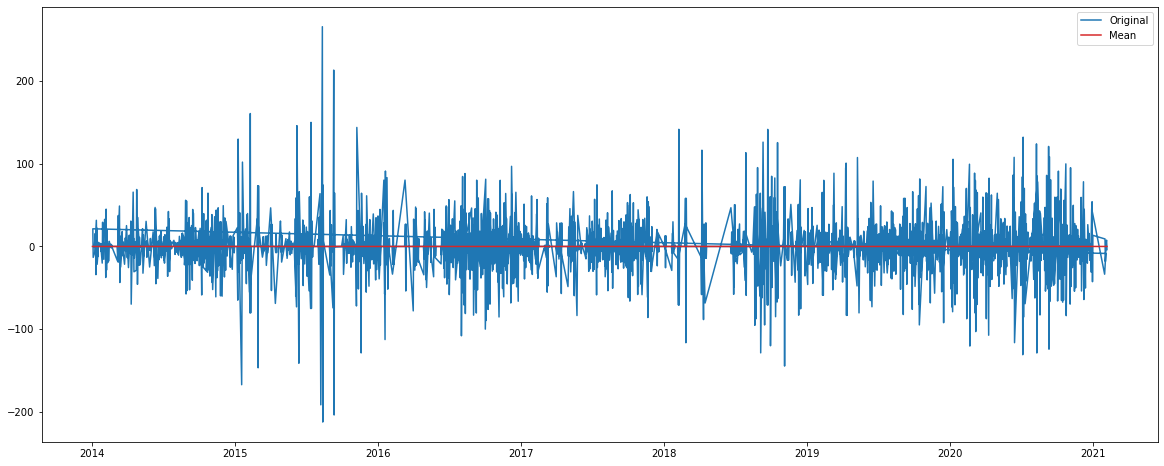

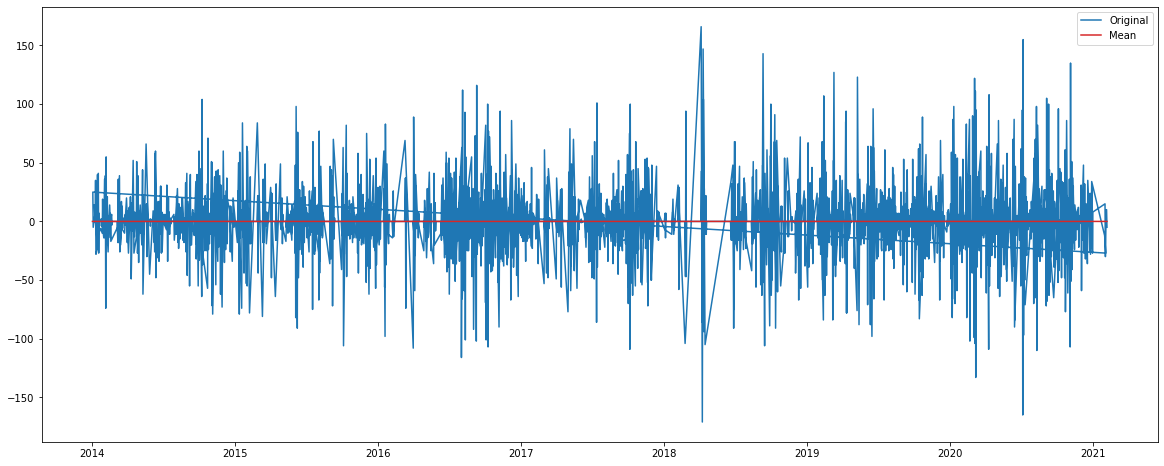

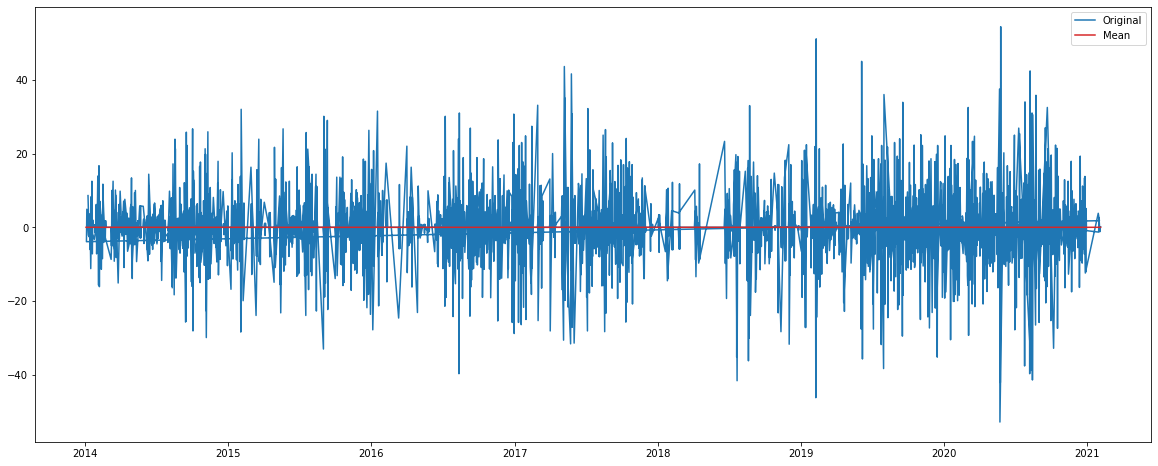

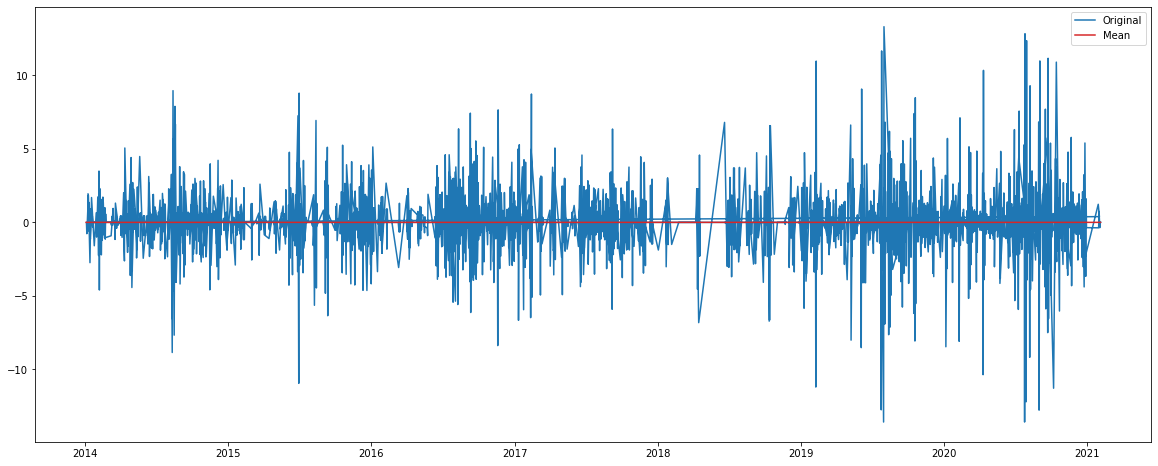

In [98]:
for i in cols:
    plt.figure(figsize=(20, 8))
    plt.plot(Queimadas_Pantanal_diff3[i], color='C0',label='Original')
    plt.plot(Queimadas_Pantanal_diff3[i].index, [Queimadas_Pantanal_diff3[i].mean() for _ in Queimadas_Pantanal_diff3[i].index], label=f'Mean', c='C03');
    plt.legend();

In [99]:
# Dropping NA Values
Queimadas_Pantanal_diff3 = Queimadas_Pantanal_diff3.dropna()

### Ajustes no Dataframe

In [117]:
Queimadas_Pantanal_diff3.to_csv('Queimadas_Pantanal_diff3.csv')

In [118]:
Queimadas_Pantanal_diff4 = pd.read_csv('Queimadas_Pantanal_diff4.csv')

In [124]:
Queimadas_Pantanal_diff4.head()

DATE  DIAS_SEM_CHUVA  RISCO_FOGO  PRECIPITACAO_DIARIA  \
2  2014-01-08            -1.0        -0.6                 19.8   
3  2014-01-09            -2.0         0.2                 -1.2   
4  2014-01-10            12.0         0.7                 -6.6   
5  2014-01-11            -9.0        -2.0                  0.0   
6  2014-01-12             3.0         2.2                  0.2   

   PRESSAO_ATMOSFERICA  TEMPERATURA_PONTO_DE_ORVALHO  TEMPERATURA_MAXIMA  \
2                 3.70                          3.36                 0.8   
3                 5.08                         -4.12                -5.2   
4                -2.37                         -4.04                -3.5   
5                 4.55                         -2.56               -11.0   
6                -0.78                         -0.94                 6.5   

   TEMPERATURA_MEDIA  TEMPERATURA_MINIMA  UMIDADE_RELATIVA_DO_AR_MEDIA  \
2               3.72                13.7                         -0.97   
3              -2.75                -1.4                         -7.12   
4              -7.66               -14.7                         15.58   
5              -6.90                -2.2                         11.88   
6               8.38                 8.6                        -34.12   

   UMIDADE_RELATIVA_MINIMA_DO_AR  VENTO_RAJADA_MAXIMA  VENTO_VELOCIDADE_MEDIA  
2                           14.0                  8.6                    1.93  
3                            5.0                 -2.2                    1.84  
4                           -1.0                  0.3                   -0.58  
5                           35.0                 -2.6                    1.35  
6                          -28.0                  1.4                   -0.47

In [120]:
Queimadas_Pantanal_diff4.drop(Queimadas_Pantanal_diff4.tail(7).index,inplace=True) # drop last n rows

In [74]:
Queimadas_Pantanal_diff4 = Queimadas_Pantanal_diff4[:-7]

In [123]:
Queimadas_Pantanal_diff4 = Queimadas_Pantanal_diff4[2:]

In [125]:
Queimadas_Pantanal_diff4.set_index('DATE', drop=True, inplace=True)
Queimadas_Pantanal_diff4.index = pd.DatetimeIndex(Queimadas_Pantanal_diff4.index)

In [126]:
Queimadas_Pantanal_diff4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2550 entries, 2014-01-08 to 2020-12-31
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DIAS_SEM_CHUVA                 2550 non-null   float64
 1   RISCO_FOGO                     2550 non-null   float64
 2   PRECIPITACAO_DIARIA            2550 non-null   float64
 3   PRESSAO_ATMOSFERICA            2550 non-null   float64
 4   TEMPERATURA_PONTO_DE_ORVALHO   2550 non-null   float64
 5   TEMPERATURA_MAXIMA             2550 non-null   float64
 6   TEMPERATURA_MEDIA              2550 non-null   float64
 7   TEMPERATURA_MINIMA             2550 non-null   float64
 8   UMIDADE_RELATIVA_DO_AR_MEDIA   2550 non-null   float64
 9   UMIDADE_RELATIVA_MINIMA_DO_AR  2550 non-null   float64
 10  VENTO_RAJADA_MAXIMA            2550 non-null   float64
 11  VENTO_VELOCIDADE_MEDIA         2550 non-null   float64
dtypes: float64(12)
memory usage: 2

In [135]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    Queimadas_Pantanal_diff4 = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in Queimadas_Pantanal_diff4.columns:
        for r in Queimadas_Pantanal_diff4.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            Queimadas_Pantanal_diff4.loc[r, c] = min_p_value
    Queimadas_Pantanal_diff4.columns = [var + '_x' for var in variables]
    Queimadas_Pantanal_diff4.index = [var + '_y' for var in variables]
    return Queimadas_Pantanal_diff4

grangers_causation_matrix(X_train, variables = X_train.columns)  

DIAS_SEM_CHUVA_x  RISCO_FOGO_x  \
DIAS_SEM_CHUVA_y                           1.0000        0.1698   
RISCO_FOGO_y                               0.3027        1.0000   
PRECIPITACAO_DIARIA_y                      0.6402        0.1539   
PRESSAO_ATMOSFERICA_y                      0.0000        0.0023   
TEMPERATURA_PONTO_DE_ORVALHO_y             0.0419        0.0811   
TEMPERATURA_MAXIMA_y                       0.0292        0.1494   
TEMPERATURA_MEDIA_y                        0.0001        0.0173   
TEMPERATURA_MINIMA_y                       0.0260        0.4704   
UMIDADE_RELATIVA_DO_AR_MEDIA_y             0.0506        0.0603   
UMIDADE_RELATIVA_MINIMA_DO_AR_y            0.0971        0.3186   
VENTO_RAJADA_MAXIMA_y                      0.1117        0.0709   
VENTO_VELOCIDADE_MEDIA_y                   0.0039        0.0657   

                                 PRECIPITACAO_DIARIA_x  PRESSAO_ATMOSFERICA_x  \
DIAS_SEM_CHUVA_y                                0.3953                 0.0053   
RISCO_FOGO_y                                    0.1033                 0.2202   
PRECIPITACAO_DIARIA_y                           1.0000                 0.0000   
PRESSAO_ATMOSFERICA_y                           0.0002                 1.0000   
TEMPERATURA_PONTO_DE_ORVALHO_y                  0.0000                 0.0000   
TEMPERATURA_MAXIMA_y                            0.0104                 0.4874   
TEMPERATURA_MEDIA_y                             0.0000                 0.0219   
TEMPERATURA_MINIMA_y                            0.0000                 0.0272   
UMIDADE_RELATIVA_DO_AR_MEDIA_y                  0.1453                 0.0005   
UMIDADE_RELATIVA_MINIMA_DO_AR_y                 0.1263                 0.0266   
VENTO_RAJADA_MAXIMA_y                           0.0168                 0.0910   
VENTO_VELOCIDADE_MEDIA_y                        0.2857                 0.1215   

                                 TEMPERATURA_PONTO_DE_ORVALHO_x  \
DIAS_SEM_CHUVA_y                                         0.1784   
RISCO_FOGO_y                                             0.6201   
PRECIPITACAO_DIARIA_y                                    0.0001   
PRESSAO_ATMOSFERICA_y                                    0.7094   
TEMPERATURA_PONTO_DE_ORVALHO_y                           1.0000   
TEMPERATURA_MAXIMA_y                                     0.0218   
TEMPERATURA_MEDIA_y                                      0.0000   
TEMPERATURA_MINIMA_y                                     0.0000   
UMIDADE_RELATIVA_DO_AR_MEDIA_y                           0.0004   
UMIDADE_RELATIVA_MINIMA_DO_AR_y                          0.0009   
VENTO_RAJADA_MAXIMA_y                                    0.3476   
VENTO_VELOCIDADE_MEDIA_y                                 0.4188   

                                 TEMPERATURA_MAXIMA_x  TEMPERATURA_MEDIA_x  \
DIAS_SEM_CHUVA_y                               0.3254               0.2654   
RISCO_FOGO_y                                   0.0453               0.6121   
PRECIPITACAO_DIARIA_y                          0.3540               0.0003   
PRESSAO_ATMOSFERICA_y                          0.1969               0.0633   
TEMPERATURA_PONTO_DE_ORVALHO_y                 0.1155               0.0000   
TEMPERATURA_MAXIMA_y                           1.0000               0.4415   
TEMPERATURA_MEDIA_y                            0.0008               1.0000   
TEMPERATURA_MINIMA_y                           0.0390               0.0003   
UMIDADE_RELATIVA_DO_AR_MEDIA_y                 0.0000               0.3052   
UMIDADE_RELATIVA_MINIMA_DO_AR_y                0.0005               0.0001   
VENTO_RAJADA_MAXIMA_y                          0.3624               0.5113   
VENTO_VELOCIDADE_MEDIA_y                       0.0154               0.0072   

                                 TEMPERATURA_MINIMA_x  \
DIAS_SEM_CHUVA_y                               0.2449   
RISCO_FOGO_y                                   0.5727   
PRECIPITACAO_DIARIA_y                          0.

### Teste de Cointegração - Johansen

In [137]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(Queimadas_Pantanal_diff4,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(Queimadas_Pantanal_diff4.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(Queimadas_Pantanal_diff4)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
DIAS_SEM_CHUVA ::  10680.16  > 311.1288  =>   True
RISCO_FOGO ::  9543.87   > 263.2603  =>   True
PRECIPITACAO_DIARIA ::  8480.29   > 219.4051  =>   True
PRESSAO_ATMOSFERICA ::  7421.76   > 179.5199  =>   True
TEMPERATURA_PONTO_DE_ORVALHO ::  6444.18   > 143.6691  =>   True
TEMPERATURA_MAXIMA ::  5480.68   > 111.7797  =>   True
TEMPERATURA_MEDIA ::  4562.12   > 83.9383   =>   True
TEMPERATURA_MINIMA ::  3681.88   > 60.0627   =>   True
UMIDADE_RELATIVA_DO_AR_MEDIA ::  2837.57   > 40.1749   =>   True
UMIDADE_RELATIVA_MINIMA_DO_AR ::  2025.99   > 24.2761   =>   True
VENTO_RAJADA_MAXIMA ::  1248.44   > 12.3212   =>   True
VENTO_VELOCIDADE_MEDIA ::  532.18    > 4.1296    =>   True


In [138]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [127]:
# Dividindo em treino e teste

X_train = Queimadas_Pantanal_diff4[:int(0.8*(len(Queimadas_Pantanal_diff4)))]
X_test = Queimadas_Pantanal_diff4[int(0.8*(len(Queimadas_Pantanal_diff4))):]


### Teste ADF(Dickey-Fuller) - Validar Estacionariedade

In [139]:
for name, column in X_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "DIAS_SEM_CHUVA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.0291
 No. Lags Chosen       = 26
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "RISCO_FOGO" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.6589
 No. Lags Chosen       = 26
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PRECIPITACAO_DIARIA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Station

### Selecionar a ordem certa para o modelo VAR.

In [142]:
model = VAR(Queimadas_Pantanal_diff4)
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\andre.paes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Lag Order = 1
AIC :  55.51696701609238
BIC :  55.87458929898084
FPE :  1.290365930864374e+24
HQIC:  55.64667279749508 

Lag Order = 2
AIC :  54.556774288106304
BIC :  55.24473315977334
FPE :  4.939799315708378e+23
HQIC:  54.80629459653683 

Lag Order = 3
AIC :  54.01509158019859
BIC :  55.03360203755661
FPE :  2.8738683213530104e+23
HQIC:  54.38450917690212 

Lag Order = 4
AIC :  53.6365705142039
BIC :  54.98584778133706
FPE :  1.968300377789429e+23
HQIC:  54.12596825042188 

Lag Order = 5
AIC :  53.489488457899476
BIC :  55.16974798639329
FPE :  1.69917275011449e+23
HQIC:  54.09894927500259 

Lag Order = 6
AIC :  53.36453480813926
BIC :  55.375992277410866
FPE :  1.4997025410730234e+23
HQIC:  54.0941417377607 

Lag Order = 7
AIC :  53.31026562244365
BIC :  55.65313694007266
FPE :  1.42063994252768e+23
HQIC:  54.160101786612636 

Lag Order = 8
AIC :  53.270029656768635
BIC :  55.94453095882855
FPE :  1.3648129872925241e+23
HQIC:  54.240178268044126 

Lag Order = 9
AIC :  53.25435134063

#### Selecionar o modelo 10

In [143]:
x = model.select_order(maxlags=10)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

### Treinar o modelo VAR da ordem selecionada(p)

In [146]:
model_fitted = model.fit(10)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, May, 2021
Time:                     01:30:03
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    56.5797
Nobs:                     2540.00    HQIC:                   54.4524
Log likelihood:          -109414.    FPE:                1.32677e+23
AIC:                      53.2413    Det(Omega_mle):     7.59033e+22
--------------------------------------------------------------------
Results for equation DIAS_SEM_CHUVA
                                       coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------
const                                     0.012063         0.390516            0.031           0.975
L1.DIAS_SEM_CHUVA                        -0.761303         0.020435     

### Correlação serial de resíduos(erros) - Durbin Watson

In [173]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(Queimadas_Pantanal_diff4.columns, out):
    print(f'{col} :', round(val, 2))
#       print('FPE : ', result.fpe)

DIAS_SEM_CHUVA : 1.98
RISCO_FOGO : 2.0
PRECIPITACAO_DIARIA : 2.0
PRESSAO_ATMOSFERICA : 2.01
TEMPERATURA_PONTO_DE_ORVALHO : 2.01
TEMPERATURA_MAXIMA : 2.0
TEMPERATURA_MEDIA : 2.01
TEMPERATURA_MINIMA : 2.0
UMIDADE_RELATIVA_DO_AR_MEDIA : 2.01
UMIDADE_RELATIVA_MINIMA_DO_AR : 2.0
VENTO_RAJADA_MAXIMA : 2.01
VENTO_VELOCIDADE_MEDIA : 2.01


In [ ]:
# Como resultado apresentado, a correção serial se mostra muito boa.

### Prever Modelo

In [175]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = Queimadas_Pantanal_diff4.values[-lag_order:]
forecast_input

10


array([[ 2.00000000e+00, -2.00000000e-01, -4.20000000e+00,
         3.80000000e-01,  0.00000000e+00, -2.00000000e-01,
         3.03800000e+01,  2.60000000e+00, -5.80000000e+00,
         2.00000000e+00,  2.40000000e+00,  1.00000000e+00],
       [ 2.00000000e+00, -1.80000000e+00, -2.60000000e+00,
        -5.31000000e+00, -1.95000000e+00,  7.60000000e+00,
         4.44000000e+00,  3.80000000e+00, -1.66500000e+01,
        -2.60000000e+01, -5.80000000e+00, -3.03000000e+00],
       [-6.00000000e+00,  2.40000000e+00,  2.00000000e-01,
         3.57000000e+00, -5.40000000e-01, -6.70000000e+00,
        -3.70000000e-01,  2.80000000e+00, -5.44000000e+00,
         2.40000000e+01, -4.10000000e+00,  3.23000000e+00],
       [-1.00000000e+01, -1.10000000e+00,  2.00000000e-01,
        -2.82000000e+00,  5.40000000e-01,  6.20000000e+00,
         1.47000000e+00, -1.80000000e+00,  3.29000000e+00,
        -2.80000000e+01, -7.20000000e+00, -4.39000000e+00],
       [ 1.10000000e+01, -2.10000000e+00,  6.2000000

#### Realizando previsão

In [176]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

NameError: name 'nobs' is not defined

## Aplicação do Modelo VAR(Vector Auto Regression)

In [128]:
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(X_train)
model_fit = model.fit()

C:\Users\andre.paes\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [129]:
# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(X_test))

In [130]:
Queimadas_Pantanal_diff4.shape

(2550, 12)

In [131]:
from math import sqrt

In [112]:
pred

DIAS_SEM_CHUVA   RISCO_FOGO PRECIPITACAO_DIARIA PRESSAO_ATMOSFERICA  \
0         0.315129    0.0185102            -1.36312            -22.4213   
1      -0.00496173   -0.0171078            0.632338             8.65843   
2       0.00791478    0.0102626           -0.205735             -1.5501   
3       -0.0226054  -0.00518399            0.043499           -0.673235   
4        0.0204025   0.00252979         -0.00256929            0.909398   
..             ...          ...                 ...                 ...   
505   -0.000752978  2.89231e-05         -0.00198449          -0.0235652   
506   -0.000752978  2.89231e-05         -0.00198449          -0.0235652   
507   -0.000752978  2.89231e-05         -0.00198449          -0.0235652   
508   -0.000752978  2.89231e-05         -0.00198449          -0.0235652   
509   -0.000752978  2.89231e-05         -0.00198449          -0.0235652   

    TEMPERATURA_PONTO_DE_ORVALHO TEMPERATURA_MAXIMA TEMPERATURA_MEDIA  \
0                        5.67744             4.3906           5.94776   
1                       -1.18758           -1.47969          -1.98255   
2                       0.283064           0.536891          0.797527   
3                      -0.103025          -0.215827         -0.384464   
4                      0.0334701          0.0807219          0.172146   
..                           ...                ...               ...   
505                  -0.00767992        -0.00460461        -0.0104514   
506                  -0.00767992        -0.00460461        -0.0104514   
507                  -0.00767992        -0.00460461        -0.0104514   
508                  -0.00767992        -0.00460461        -0.0104514   
509                  -0.00767992        -0.00460461        -0.0104514   

    TEMPERATURA_MINIMA UMIDADE_RELATIVA_DO_AR_MEDIA  \
0              5.29918                      2.52526   
1             -1.19407                     0.721263   
2              0.25331                    -0.573565   
3           -0.0584724                     0.264729   
4           -0.0109521                   -0.0751824   
..                 ...                          ...   
505         -0.0103039                   0.00858233   
506         -0.0103039                   0.00858233   
507         -0.0103039                   0.00858233   
508         -0.0103039                   0.00858233   
509         -0.0103039                   0.00858233   

    UMIDADE_RELATIVA_MINIMA_DO_AR VENTO_RAJADA_MAXIMA VENTO_VELOCIDADE_MEDIA  
0                         1.30323            0.843926              0.0387099  
1                         1.81935            -0.21065             -0.0529257  
2                        -1.23252           0.0582978              0.0420775  
3                        0.628522          -0.0080219               -0.01991  
4                       -0.281004          0.00730953              0.0147387  
..                            ...                 ...                    ...  
505                    0.00547279          0.00467329              0.0027926  
506                    0.00547279          0.00467329              0.0027926  
507                    0.00547279          0.00467329              0.0027926  
508                    0.00547279          0.00467329              0.0027926  
509                    0.00547279          0.00467329              0.0027926  

[510 rows x 12 columns]

In [132]:
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,12):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

# check rmse
# for i in cols:
#     print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])))

for i in range(len(cols)):
    print("\n\npred - ", pred.iloc[i])
    print("X_test - ", X_test.iloc[i])
    print('Valor de RMSE para', i, 'é : ', np.sqrt(mean_squared_error(pred.iloc[i], X_test.iloc[i])))



pred -  DIAS_SEM_CHUVA                    0.315129
RISCO_FOGO                       0.0185102
PRECIPITACAO_DIARIA               -1.36312
PRESSAO_ATMOSFERICA               -22.4213
TEMPERATURA_PONTO_DE_ORVALHO       5.67744
TEMPERATURA_MAXIMA                  4.3906
TEMPERATURA_MEDIA                  5.94776
TEMPERATURA_MINIMA                 5.29918
UMIDADE_RELATIVA_DO_AR_MEDIA       2.52526
UMIDADE_RELATIVA_MINIMA_DO_AR      1.30323
VENTO_RAJADA_MAXIMA               0.843926
VENTO_VELOCIDADE_MEDIA           0.0387099
Name: 0, dtype: object
X_test -  DIAS_SEM_CHUVA                    3.00
RISCO_FOGO                        0.00
PRECIPITACAO_DIARIA               2.20
PRESSAO_ATMOSFERICA               4.66
TEMPERATURA_PONTO_DE_ORVALHO      7.14
TEMPERATURA_MAXIMA              -10.30
TEMPERATURA_MEDIA                -1.45
TEMPERATURA_MINIMA               -7.30
UMIDADE_RELATIVA_DO_AR_MEDIA     26.99
UMIDADE_RELATIVA_MINIMA_DO_AR    40.00
VENTO_RAJADA_MAXIMA              -3.70
VENTO_VELOCI

In [ ]:
# boost

In [61]:
from sklearn.ensemble import RandomForestRegressor

n_jobs = -1
forest = RandomForestRegressor(n_jobs=-1, max_depth=7)